# Rede CNN - Modelo 2

## Dataset Respiratory_Sound_Database_Pneumo_Healthy_Only - Dataset 2 - slide5

In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import librosa
import librosa.display
import glob

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Necessário na minha máquina. Estava ocorrendo um erro devido à GPU e esse código resolveu.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
GROUP_TRAIN = 'slide5'
GROUP_TEST = 'slide5'
DATASET = 'dataset_2'
DURATION = 5
SIZE = 216
CSV_TRAIN = 'train2.csv'
CSV_TEST = 'test2.csv'
MODEL_NAME = f'CNN2_{DATASET}_{GROUP_TRAIN}'

In [4]:
train_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TRAIN}/train/**/*.wav', recursive=True)
train_file_names = [os.path.splitext(os.path.basename(p))[0] for p in train_file_paths]

test_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TEST}/test/**/*.wav', recursive=True)
test_file_names = [os.path.splitext(os.path.basename(p))[0] for p in test_file_paths]

In [5]:
train_p_id_in_file = [] # patient IDs corresponding to each file
test_p_id_in_file = [] # patient IDs corresponding to each file
for name in train_file_names:
    train_p_id_in_file.append(int(name[:3]))

for name in test_file_names:
    test_p_id_in_file.append(int(name[:3]))

train_p_id_in_file = np.array(train_p_id_in_file)
test_p_id_in_file = np.array(test_p_id_in_file) 

In [6]:
max_pad_len = SIZE

os.makedirs("features/", exist_ok=True)

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
    feature = os.path.splitext(os.path.basename(file_name))[0] + ".npy"
#     if (os.path.isfile(os.path.join("./Respiratory_Sound_Database/features/", feature))):
#         return np.load(os.path.join("./Respiratory_Sound_Database/features/", feature))
    
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=DURATION) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    np.save(os.path.join("./features/", feature), mfccs)
    return mfccs

In [7]:
#filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [8]:
train_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TRAIN}", header=None) # patient diagnosis file
test_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TEST}", header=None) # patient diagnosis file
train_p_diag.head(5)

,0,1
0,123,Healthy
1,125,Healthy
2,126,Healthy
3,127,Healthy
4,136,Healthy


In [9]:
train_labels = np.array([train_p_diag[train_p_diag[0] == x][1].values[0] for x in train_p_id_in_file]) 
test_labels = np.array([test_p_diag[test_p_diag[0] == x][1].values[0] for x in test_p_id_in_file]) 

In [10]:
train_features = [] 
test_features = []

for file_name in train_file_paths:
    data = extract_features(file_name)
    train_features.append(data)

for file_name in test_file_paths:
    data = extract_features(file_name)
    test_features.append(data)

print('Finished feature extraction from ', (len(train_features)+len(train_features)), ' files')
train_features = np.array(train_features)
test_features = np.array(test_features)

Finished feature extraction from  896  files


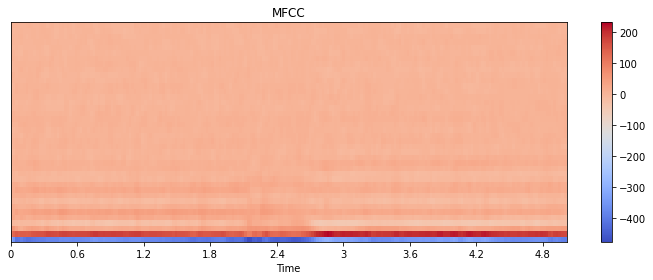

In [11]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [12]:
np.unique(train_labels)

array(['Healthy', 'Pneumonia'], dtype='<U9')

In [13]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['Healthy' 'Pneumonia']
 ['256' '192']]
[['Healthy' 'Pneumonia']
 ['24' '104']]


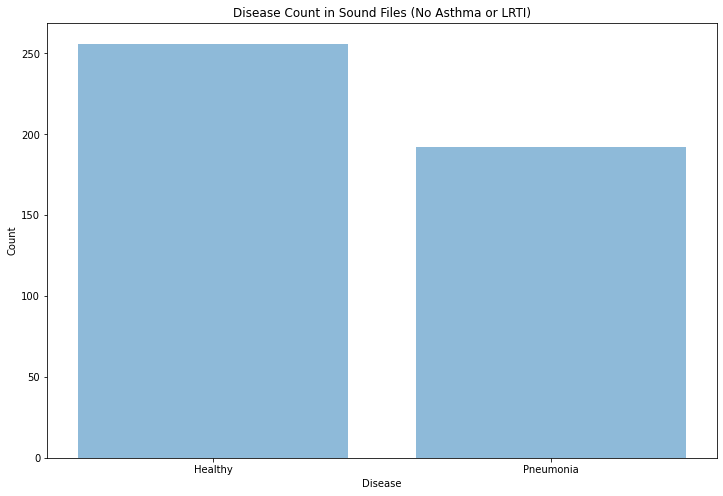

In [14]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [15]:
# One-hot encode labels
le = LabelEncoder()
le.fit(train_labels)
train_labels_cat = to_categorical(le.transform(train_labels)) 
test_labels_cat = to_categorical(le.transform(test_labels)) 

In [16]:
train_features.shape

(448, 40, 216)

In [17]:
train_features = np.reshape(train_features, (*train_features.shape,1)) 
print(train_features.shape, train_labels_cat.shape)
test_features = np.reshape(test_features, (*test_features.shape,1)) 
print(test_features.shape, test_labels_cat.shape)

(448, 40, 216, 1) (448, 2)
(128, 40, 216, 1) (128, 2)


In [18]:
# train test split
x_train, x_val, y_train, y_val = train_test_split(train_features, train_labels_cat, test_size=0.2, random_state = 42)
x_test, y_test = test_features, test_labels_cat

**CNN model architecture**

In [19]:
num_labels = train_labels_cat.shape[1]

num_rows = 40
num_columns = SIZE
num_channels = 1

filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=8, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=4, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [21]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 215, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 107, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 107, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 106, 16)       2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 53, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 53, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 52, 8)          5

**Training**

Here we will train the model. If we have a trained model, we can load it instead from the next cell.

In [22]:
# train model
num_epochs = 500
num_batch_size = 10

os.makedirs('models', exist_ok=True)
callbacks = [
    ModelCheckpoint(
        filepath='models/' + MODEL_NAME + '_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 358 samples, validate on 90 samples
Epoch 1/500
280/358 [======================>.......] - ETA: 0s - loss: 4.6879 - accuracy: 0.5643
Epoch 00001: val_accuracy improved from -inf to 0.51111, saving model to models/CNN2_dataset_2_slide5_01.h5
358/358 [==============================] - 1s 3ms/sample - loss: 4.0652 - accuracy: 0.5559 - val_loss: 0.6933 - val_accuracy: 0.5111
Epoch 2/500
280/358 [======================>.......] - ETA: 0s - loss: 1.5389 - accuracy: 0.4857
Epoch 00002: val_accuracy improved from 0.51111 to 0.56667, saving model to models/CNN2_dataset_2_slide5_02.h5
358/358 [==============================] - 0s 710us/sample - loss: 1.4254 - accuracy: 0.5140 - val_loss: 0.6920 - val_accuracy: 0.5667
Epoch 3/500
270/358 [=====================>........] - ETA: 0s - loss: 1.0034 - accuracy: 0.5444
Epoch 00003: val_accuracy did not improve from 0.56667
358/358 [==============================] - 0s 674us/sample - loss: 0.9710 - accuracy: 0.5587 - val_loss: 0.6909 - val_accu

**Plot accuracies and losses**

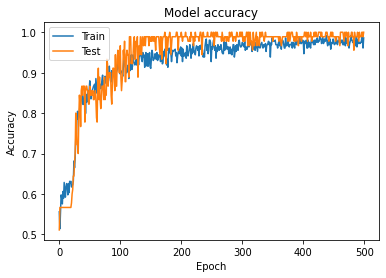

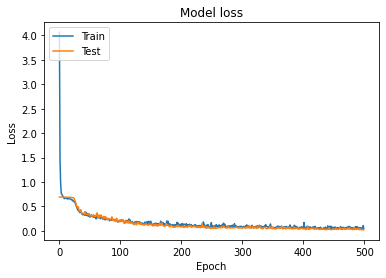

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Teste

In [24]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.375


In [25]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=2 # number of classes

In [26]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [27]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names = ['Healthy', 'Pneumonia']

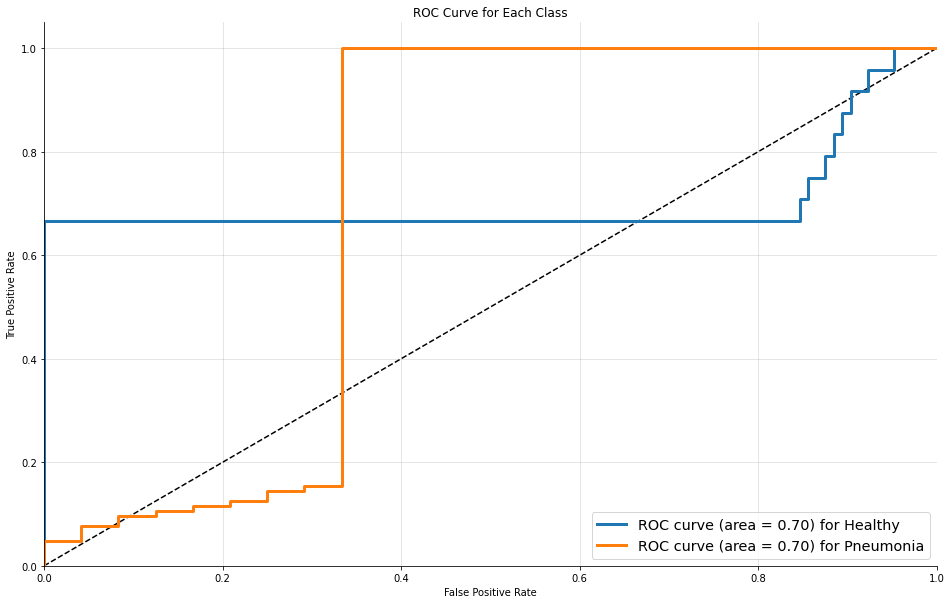

In [28]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [29]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

     Healthy       0.18      0.67      0.29        24
   Pneumonia       0.80      0.31      0.44       104

    accuracy                           0.38       128
   macro avg       0.49      0.49      0.37       128
weighted avg       0.68      0.38      0.41       128



In [30]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[16  8]
 [72 32]]


In [31]:
import itertools
def plot_confusion_matrix(cm, unique_labels, show=True, output=None,
                          title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() + 1).astype(str))
    plt.yticks(tick_marks)

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if show:
        plt.show()
    if output is not None:
        plt.savefig(output)
    plt.close()
    return output


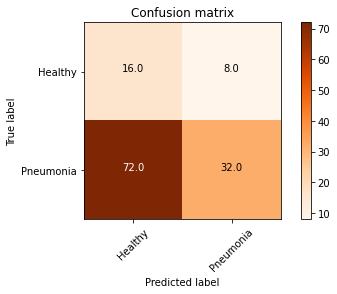

In [32]:
plot_confusion_matrix(confusion_matrix(y_testclass, classpreds), unique_labels=["Healthy", "Pneumonia"])